In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py
from keras.models import load_model
from collections import deque

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

In [ ]:
"""  Function to get 20 frames from the vedio and convert it into a suitable format  """


def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


### **Labelling the data**

In [ ]:
data_path = "/content/drive/MyDrive/PBL/fightdata"

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [ ]:
names, labels = label_video_names(data_path)

In [ ]:
names[12]

'fi363_xvid.avi'

In [ ]:
frames = get_frames(data_path, names[9])


In [ ]:
visible_frame = (frames*255).astype('uint8')


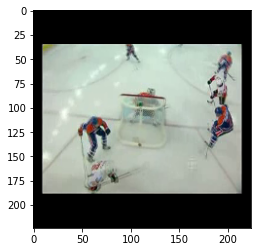

In [ ]:
plt.imshow(visible_frame[3])


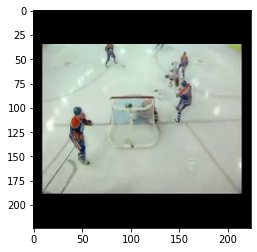

In [ ]:
plt.imshow(visible_frame[15])


### **Loading the VGG16 model**

In [ ]:
#Loading the pretrained model

image_model = VGG16(include_top=True, weights='imagenet')


553467904/553467096 [==============================] - 8s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
input_shape = image_model.get_layer('input_1').output_shape[:]
input_shape = list(input_shape[0])
input_shape = tuple(input_shape[1:3])
input_shape

(224, 224)

In [ ]:
# We will use the output of the layer 'fc2' prior to the final layer

transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [ ]:
# Function to process 20 frames through VGG16 and get transfer values

def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values


In [ ]:
# Function to process one video through VGG16 each function call

def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [ ]:
# Function to get features form all videos and save it

def make_files(n_files):
    
    gen = proces_transfer(names_training, data_path, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1    

In [ ]:

def make_files_test(n_files):
    
    gen = proces_transfer(names_test, data_path, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
# Function to print the amount of videos processed

def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
# Splitting the dataset

training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
make_files(training_set)


In [ ]:
make_files_test(test_set)


- Progress: 4.2%

KeyboardInterrupt: ignored

In [ ]:
# Load the transfer values into the disk

In [ ]:
#Function to create batches

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()


In [ ]:
data_test, target_test = process_alldata_test()


In [ ]:
# Creating the LSTM model

chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size), return_sequences=False))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [ ]:
model.input_shape

(None, 20, 4096)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               9439232   
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0

In [ ]:
epoch = 200
batchS = 512

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 1s - loss: 0.3340 - accuracy: 0.4920 - val_loss: 0.3288 - val_accuracy: 0.4828
Epoch 2/200
2/2 - 0s - loss: 0.2937 - accuracy: 0.5213 - val_loss: 0.2586 - val_accuracy: 0.5172
Epoch 3/200
2/2 - 0s - loss: 0.2636 - accuracy: 0.4813 - val_loss: 0.2498 - val_accuracy: 0.4828
Epoch 4/200
2/2 - 0s - loss: 0.2493 - accuracy: 0.5187 - val_loss: 0.2611 - val_accuracy: 0.4828
Epoch 5/200
2/2 - 0s - loss: 0.2533 - accuracy: 0.5187 - val_loss: 0.2508 - val_accuracy: 0.4828
Epoch 6/200
2/2 - 0s - loss: 0.2479 - accuracy: 0.5240 - val_loss: 0.2485 - val_accuracy: 0.5172
Epoch 7/200
2/2 - 0s - loss: 0.2517 - accuracy: 0.4813 - val_loss: 0.2475 - val_accuracy: 0.5172
Epoch 8/200
2/2 - 0s - loss: 0.2494 - accuracy: 0.5760 - val_loss: 0.2478 - val_accuracy: 0.4828
Epoch 9/200
2/2 - 0s - loss: 0.2466 - accuracy: 0.5187 - val_loss: 0.2491 - val_accuracy: 0.4828
Epoch 10/200
2/2 - 0s - loss: 0.2450 - accuracy: 0.5187 - val_loss: 0.2432 - val_accuracy: 0.5000
Epoch 11/200
2/2 - 0s - loss:

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))


9/9 [==============================] - 0s 15ms/step - loss: 0.1383 - accuracy: 0.8346


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.13827531039714813
accuracy 0.8346154093742371


In [ ]:
model.save_weights("/content/drive/MyDrive/PBL/trained_weights/model1.h5")
model.save("/content/drive/MyDrive/PBL/trained_weights/savedmodel.h5")

In [ ]:
modelx = load_model("/content/drive/MyDrive/PBL/trained_weights/savedmodel.h5")
output_vedio = "/content/drive/MyDrive/PBL/output1.avi"
Queue = deque(maxlen=128)
mean = np.array([123,68, 116.779, 103.939][::1], dtype='float32')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


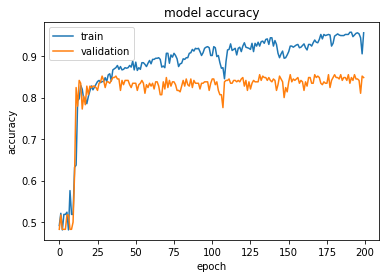

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


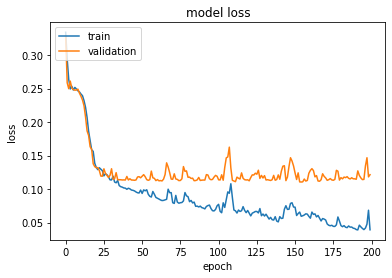

In [ ]:
#Plotting the accuracy and loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
testx = get_transfer_values("/content/drive/MyDrive/PBL/fightdata", "fi30_xvid.avi")
testx = np.expand_dims(testx, axis=0)
testx.shape


(1, 20, 4096)

In [ ]:
a = model.predict(np.array(testx))
np.argmax(a)

In [ ]:
from google.colab.patches import cv2_imshow

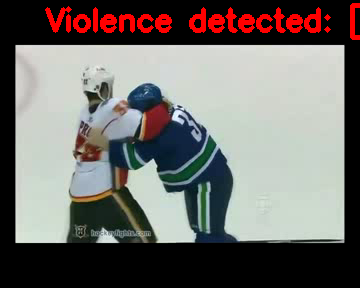

Finalizing.........


error: ignored

In [ ]:


capture_vedio = cv2.VideoCapture("/content/drive/MyDrive/PBL/fightdata/fi30_xvid.avi")
writer = None
(Width, Height) = (None, None)

while(True):
  taken, frame = capture_vedio.read()

  if Width is None or Height is None:
    (Width, Height) = frame.shape[:2]

  count = 0

  images=[]
  output = frame
  while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        taken, frame = capture_vedio.read()
    
        count += 1
        
        resul = np.array(images)
    
        resul = (resul / 255.).astype(np.float16)  



  
  preds = modelx.predict(np.array(testx)) 
  Queue.append(preds)
  results = np.array(Queue).mean(axis=0)
  i = np.argmax(results)
  label = [0,1]
  text = " Violence detected: {} ".format(label)
  cv2.putText(output, text, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 4)

  
  fourcc = cv2.VideoWriter_fourcc(*"HJPG")
  writer = cv2.VideoWriter("outputvedio", fourcc, 15, (Width, Height), True)
  

  cv2_imshow(output)
  key = cv2.waitKey(1) & 0xFF
    
  if key == ord("q"):
     break

  print("Finalizing.........")
  writer.release()
  capture_vedio.release()    


In [ ]:
import cv2

In [ ]:
# Copy 1

capture_vedio = cv2.VideoCapture("/content/drive/MyDrive/PBL/fi1_xvid.avi")
writer = None
(Width, Height) = (None, None)

while(True):
  (taken, frame) = capture_vedio.read()

  if Width is None or Height is None:
    (Width, Height) = frame.shape[:2]


  output = frame.copy()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.resize(frame, (244, 244)).astype("float32")
  
  preds = modelx.predict(frame)[0] 
  Queue.append(preds)
  results = np.array(Queue).mean(axis=0)
  i = np.argmax(results)
  label = lb.classes[i]
  text = " Violence detected: {} ".format(label)
  cv2.putText(output, text, (45, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 0), 5)

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"HJPG")
    writer = cv2.VideoWriter("outputvedio", fourcc, 30, (Width, Height), True)
    writer = write(output)

    cv2.imshow("In progress", output)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
      break

  print("Finalizing.........")
  writer.release()
  capture_video.release()    


In [ ]:
a = np.array(data)
a.shape